# Lesson 3. Land Cover Classification

# Land Cover classification using Random Forest with in-situ and EO data in Finland

![map](img/Close-up.png)

## Background

This type of land cover interpretation provides the background for various environmental monitoring applications, such as the calculation of environmental indicators (e.g. "land degradation"), biotope inventories, nutrient loss modelling, and assessment of the consequences of legislation or land use planning.  

The **Finnish Environment Institute (SYKE)** has worked since the 1990s recognizing the importance of such up-to-date spatial data. SYKE has participated in the [European land cover monitoring](https://land.copernicus.eu/) since the early 2000s within the **Corine** programme, which has produced Corine land cover interpretations and modifications for the years 2000, 2006, 2012, and 2018. In addition, more local interpretations have been made with various partners, such as the remote sensing of Northern Lapland carried out for Metsähallitus in recent years. There are also various projects, such as FEO and Geoportti, which aim to improve the availability of environmental spatial information. 

More information check the [**Land Cover Monitoring in Finland**](https://www.syke.fi/fi-FI/Avoin_tieto/Seurantatiedot/Maanpeitteen_seuranta )


## Objective 

- To perform Land Cover Classification using Random Forest ML with Python in a selected region of Finland.
- To use the [Lucas 2018](https://ckan.ymparisto.fi/en/dataset/lucas2018) inventory dataset and Earth Observation data from the [GeoCubes Finland](https://vm0160.kaj.pouta.csc.fi/geocubes/) service.


## Learning outcome

Generally, during this tutorial, you will learn:

 * How to conduct a generalized Land Cover classification using the scikit-learn Python library
 * How to use and download data from the GeoCubes service
 * How to use the Dask library in CSC's Puhti supercomputer
 * How to interpret the classification results and improve them

 
## Input datasets: 

### 1. **In situ data - Lucas 2018** 

In this exercise the In-situ dataset is the **Lucas 2018 land inventory** dataset from Finland. LUCAS (Land USe and Coverage Area frame Survey) is a land inventory organized by EUROSTAT, the statistical office of the European Union, which collects data on land cover and land use from the survey plots. There are about 330,000 plots throughout the EU, of which about 17,000 are in Finland. Part of the data collection is done by field visits and part by interpreting aerial photographs.  

We are going to download the Lucas 2018 scores for the wholeof  Finland as *lucas_2018.shp* during the exercise and you will find it available in the `output` folder. If you want to explore it independently you can [download it here](https://a3s.fi/geoportti_training/lucas2018.tar). The dataset contains the main land cover group in the column "lc_class" including province delimitation. 

A more detailed land cover class can be found in column `LC1` and for more detailed information on land cover and use classes check the [Lucas 2018 Technical Document](https://ec.europa.eu/eurostat/documents/205002/8072634/LUCAS2018-C3-Classification.pdf) if needed.
   
Here is a quick summary of the codes:

| Code   | Land Cover                 
| :---   |     :----:                 
| 1      | Build up areas             
| 2      | Agriculture                
| 3      | Forests                    
| 4      | Sparsely vegetated forests 
| 5      | Grasslands                 
| 6      | Unvegetated soil           
| 7      | Water                      
| 8      | Wetlands                   

### 2. **EO data features**
 
In this exercise, you will use raster datasets found in the [GeoCubes Finland](https://vm0160.kaj.pouta.csc.fi/geocubes/) service as classification features. So, select a province and download the data of your choice, delimited by that province, using a pixel size of 10 m.

The variables we will use as classification features from **GeoCubes Finland** are:

| Name              | Feature 
| :---              |     :----: 
| ndvi_max          | Normalized Vegetation Index  
| dem               | Digital Elevation Model      
| tree_classes      | Tree density          
| veg_height        | Vegetation density
| canopy_cover      | Canopy cover       
| s2_nir            | Sentinel 2 Near Infrared
| s2_rgb            | Sentinel 2 bands: red, green, and blue      

## Study area

For this exercise, we have selected the Lapland province. Feel free to choose the area of your preference. You will notice that even a smaller area can be selected by Bounding Box (Grid) from every province. Follow step by step the exercise.

## HPC Resources

CSC Machine-Puhti:

- *Partition
- *Cores* 8
- *Local Memory* 64 Gb
- *Disk* 240 Gb
 

 

# Import needed Python libraries

In [2]:
# for geo-data analysis
import rasterio
from rasterio.merge import merge
from rasterio.plot import show, show_hist
from shapely.geometry import Polygon
import rioxarray as rxr
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd

# for visualization
# import datashader as ds
# import datashader.transfer_functions as ds_function
# from datashader.utils import export_image
import matplotlib.pyplot as plt
# import colorcet as cc

import glob
import os, sys, shutil
import urllib
import time
from datetime import date

# for parallelization
import multiprocessing as mp
from dask import delayed
from dask import compute
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import dask
import dask.array as da

# for ML modelling and running
from sklearn.preprocessing import LabelEncoder
from pprint import pprint
from tqdm.notebook import tqdm
import itertools

import tpot
import argparse
import pickle

# Import Point-EO from local

The PointEO is a Python library (scripts) stored locally that were developed internally in **SYKE**. The purpose of the library is to facilitate the land use prediction using the Random Forest model. By packing the function in a local library it is easier to call them all just when they are needed and makes the process simpler. 

The library is given already in the local folder and you just need to run the command `sys.path.append()` to call available libraries in your home directory. 

Feel free to take a look at the [Point-EO GitHub Repository](https://github.com/sykefi/point-eo).

![pointeo](img/point-eo.png)

In [5]:
# adding point-eo from local scripts
home = os.getcwd()
sys.path.append(home)

import point_eo.scripts.sample_xarray as sample_xarray # NOTE: this is my modification to original point-eo repo
import point_eo.scripts.analysis as analysis
import point_eo.scripts.tpot_train as tpot_train
import point_eo.scripts.predict as predict
import point_eo.scripts.postprocess_prediction as postprocess_prediction

We will create an output folder and we will name it `basepth`

In [6]:
# results folder
if not os.path.exists('output'):
    os.makedirs('output')
    
basepth = os.path.join(home, 'output')

# Download Lucas 2018 from Allas

The dataset was stored previously in Allas, the CSC's cloud storage, and we will download it to our root folder for further use using `wget`. In case you want to save in a specific folder use the command `-P folder_path` 

In [4]:
!wget -N https://a3s.fi/geoportti_training/lucas2018.tar

--2024-04-08 17:04:47--  https://a3s.fi/geoportti_training/lucas2018.tar
Resolving a3s.fi (a3s.fi)... 86.50.254.19, 86.50.254.18
Connecting to a3s.fi (a3s.fi)|86.50.254.19|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘lucas2018.tar’ not modified on server. Omitting download.



Then, we will decompress the datasets in the root folder using the command `tar`. The command `tar` unzip previously compressed data and you need to specify the *.tar* file and the folder where you want to decompress using `-C` command. 

In [5]:
!tar -xf 'lucas2018.tar'

Once you have run the cell you will find the **Lucas 2018** data in the subfolder `training_data`.

The folder contains the data for the whole of Finland and each province.

Let's take a look at the files and let's visualize the data at the national level and the selected province we are working on.

In [6]:
# check the files in Lucas 2018 training_data folder
lucas_paths = glob.glob(os.path.join(home, 'training_data/*.shp'))

lucas_files = [path.split('/')[-1] for path in lucas_paths]

print('Files for Lucas 2018 per province:\n')

for file in sorted(lucas_files):

    print('  ', file)

Files for Lucas 2018 per province:

   lucas2018_10_etelasavo.shp
   lucas2018_11_pohjoissavo.shp
   lucas2018_12_pohjoiskarjala.shp
   lucas2018_13_keskisuomi.shp
   lucas2018_14_etelapohjanmaa.shp
   lucas2018_15_pohjanmaa.shp
   lucas2018_16_keskipohjanmaa.shp
   lucas2018_17_pohjoispohjanmaa.shp
   lucas2018_18_kainuu.shp
   lucas2018_19_lappi.shp
   lucas2018_1_uusimaa.shp
   lucas2018_21_ahvenanmaa.shp
   lucas2018_2_varsinaissuomi.shp
   lucas2018_4_satakunta.shp
   lucas2018_5_kantahame.shp
   lucas2018_6_pirkanmaa.shp
   lucas2018_7_paijathame.shp
   lucas2018_8_kymenlaakso.shp
   lucas2018_9_etelakarjala.shp
   lucas_2018.shp


## Lucas 2018 in Finland

Let's give a quick look at national level.

In [7]:
%%time

# Lucas 2018 in Finland
fi_path = os.path.join(home, 'training_data/lucas_2018.shp')
lucas2018_fi = gpd.read_file(fi_path)

CPU times: user 3.44 s, sys: 84 ms, total: 3.52 s
Wall time: 5.33 s


In [8]:
lucas2018_fi.dtypes

OBJECTID         int64
POINT_ID         int64
OFFICE_PI        int64
SURVEYDATE      object
OBS_DIST        object
OBS_DIRECT       int64
OBS_TYPE         int64
LC1             object
LC2             object
LU1             object
LU2             object
LC1_name        object
LU1_name        object
photolinkN      object
photolinkE      object
photolinkS      object
photolinkW      object
photolinkP      object
LCluokka         int64
maakunta_1       int64
geometry      geometry
dtype: object

In [9]:
lucas2018_fi.LU1_name.value_counts()

LU1_name
Forestry                                                 7864
Agriculture                                              3535
Semi-natural and natural areas not in use                2452
Residential                                               711
Road transport                                            698
Amenities, museums, leisure                               224
Mining and quarrying                                      171
Fallow land                                                76
Community services                                         60
Electricity, gas and thermal power distribution            58
Other abandoned areas                                      56
Commerce                                                   38
Railway transport                                          34
Sport                                                      34
Kitchen garden                                             33
Logistics and storage                                      28

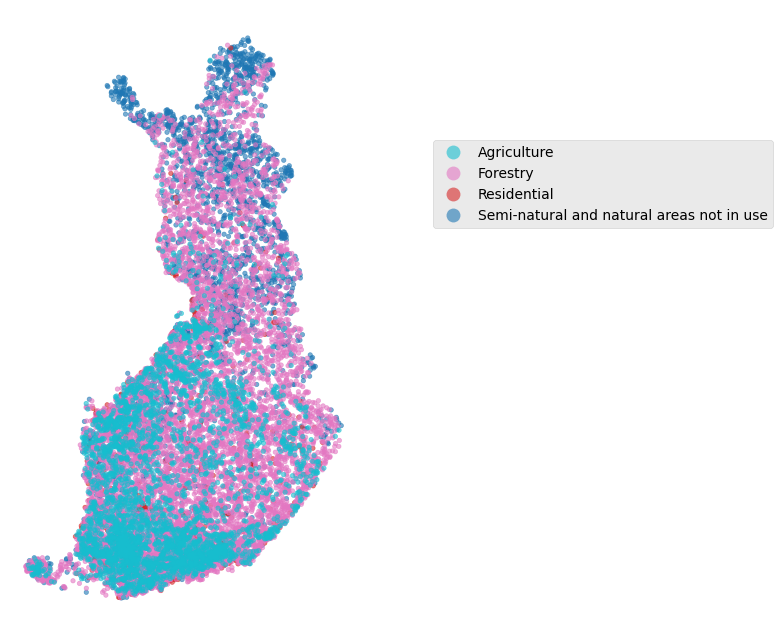

In [10]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(6, 8))

# set class
class_name = ['Forestry', 'Agriculture', 'Residential', 'Semi-natural and natural areas not in use']
lu_class = lucas2018_fi.loc[lucas2018_fi['LU1_name'].isin(class_name)].sort_values('LU1_name', ascending=False)

# plot
lu_class.plot(ax=ax,
               column='LU1_name', 
               categorical=True, 
               cmap = 'tab10_r',
               markersize= 10,
               alpha = 0.6,
               legend=True,
               legend_kwds={'bbox_to_anchor':(1.2, 0.8)}
              )

plt.axis('off');

## Lucas 2018 in Lapland

We will work in this exercise using the **Lapland** region.

In [11]:
# get path
lapland_path = os.path.join(home, 'training_data/lucas2018_19_lappi.shp')

# read
lucas2018_lapland = gpd.read_file(lapland_path)

In [12]:
lucas2018_lapland.LU1_name.value_counts()

LU1_name
Semi-natural and natural areas not in use          1333
Forestry                                           1053
Agriculture                                          61
Road transport                                       50
Residential                                          26
Amenities, museums, leisure                          21
Mining and quarrying                                 12
Other abandoned areas                                 9
Community services                                    8
Electricity, gas and thermal power distribution       4
Abandoned transport areas                             4
Fallow land                                           3
Air transport                                         2
Commerce                                              2
Water transport                                       2
Logistics and storage                                 1
Construction                                          1
Wood based products                    

In [13]:
lucas2018_lapland.crs.name

'ETRS89 / TM35FIN(E,N)'

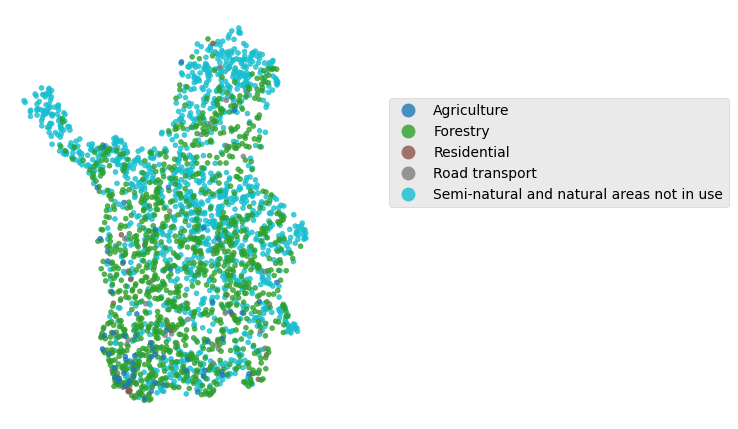

In [14]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(4, 6))

# set class
class_name = ['Forestry', 'Agriculture', 'Residential', 'Semi-natural and natural areas not in use', 'Road transport',]
lu_class = lucas2018_lapland.loc[lucas2018_lapland['LU1_name'].isin(class_name)].sort_values('LU1_name', ascending=False)

# plot
lu_class.plot(ax=ax,
               column='LU1_name', 
               categorical=True, 
               cmap = 'tab10',
               markersize= 12,
               alpha = 0.8,
               legend=True,
               legend_kwds={'bbox_to_anchor':(1.2, 0.8)}
              )

plt.axis('off');

## Download input rasters from Allas

To keep this exercise straightforward we have stored the input raster in Allas. This will make it easy to download and use in the workflow.

You will download a folder `input_data` that contains:

| Filename                               | Feature                                  | Used in model 
| :---                                   |     :----                                |     :----
| ndvi_max_2021_lapland.tif              | Normalized Vegetation Index              | Yes
| km2_lapland.tif                         | Digital Elevation Model                 | Yes
| tree_classes_lapland.tif                | Tree density                            | Yes
| vegetation_height_lapland.tif           | Vegetation density                      | Yes
| canopy_cover_lapland.tif                | Canopy cover                            | Yes
| s2_nir_lapland.tif                     | Sentinel 2 Near Infrared                 | Yes
| s2_rgb_lapland.tif                     | Sentinel 2 bands: red, green, and blue   | No 
| s2_rgb_lapland_band1.tif                     | Sentinel 2 band blue               | Yes
| s2_rgb_lapland_band2.tif                     | Sentinel 2 band green              | Yes
| s2_rgb_lapland_band3.tif                     | Sentinel 2 band red                | Yes

In [15]:
!wget -N https://a3s.fi/geoportti_training/input_data.tar

--2024-04-08 17:05:02--  https://a3s.fi/geoportti_training/input_data.tar
Resolving a3s.fi (a3s.fi)... 86.50.254.18, 86.50.254.19
Connecting to a3s.fi (a3s.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘input_data.tar’ not modified on server. Omitting download.



In [16]:
!tar -xf 'input_data.tar'

## Using GeoCubes for downloading data (Optional)

GeoCubes offers raster data for different provinces.  You can download datasets using `urllib` by selecting the region and data from API links in [GeoCubes API access](https://vm0160.kaj.pouta.csc.fi/geocubes/apiaccess/). 

```{attention}
<i>If you want to download data from <b>GeoCubes</b> using another Finland province of your interest be aware that sometimes the API might not be working due to maintenance</i>
```

The next code will help you to download data using API endpoints. It uses a new created folder and `urllib.request.urlretrieve()`

```
            # -- Create a results folder
            
            if not os.path.exists('input_data'):
                os.makedirs('input_data')
                
            # -- Function to download from GeoCubes
            
            def download_data(url, output_folder, file_name):
                '''
                Download images from URL to a local path 
                    - params: URL, string
                    - output_folder, string
                    - file_name, string
                '''
                # get url and path
                download_url = url
                out_fn = os.path.join(output_folder, file_name)
                
                print(f"Downloading... {download_url}")
                
                try:
                urllib request
                    r = urllib.request.urlretrieve(download_url, out_fn)
                    
                    print(f"Download completed. Results saved to {out_fn}/n")
            
                except:
            
                    print(f"URL not valid {download_url}\n")
            
            # -- Using function (Example)
            
            url = 'https://vm0160.kaj.pouta.csc.fi/geocubes/clip/10/puustoisuusluokat/maakuntajako:19/202'
            input_data_folder = os.path.join(home, 'input_data')
            file_name = 'tree_classes_lapland.tif'
            
            # run
            download_data(url, input_data_folder, file_name)

```



## Split multi-band rasters to single-band (Optional)

If you have downloaded data from a different province using **GeoCubes** be aware that `RGB images` are a composite of `Red, Green, and Blue` images. As we prefer to have independent data it is recommended to split this multi-band image into single-band images.

For that, you can use the next function in your workflow:

```
            # -- Function to split a multi-band raster
            
            def split_multiband_raster(input_path, output_folder):
                '''
                Read from local folder a multi-band image and split it single-band
                    - input_path: multi-band tif
                    - output_folder: store single-band tif folder
                '''
                
                # Open the multiband raster
                ds = rxr.open_rasterio(input_path)
            
                # Get the number of bands
                num_bands = ds.shape[0]
            
                # Loop through each band
                for band_index in range(num_bands):
                    
                    # Get the band data
                    band = ds[band_index]
            
                    # Create the output file name
                    output_name = f"multi-band_split_band_{band_index + 1}.tif"
                    output_path = os.path.join(output_folder, output_name)
            
                    # Save the band as a single-band raster
                    band.rio.to_raster(output_path)
            
                    print(f"Band {band_index + 1} saved as {output_path}")
            
             # -- Using function (Example)
            
            input_raster = "input_data/s2_rgb_lapland.tif"
            output_folder = "input_data"
            
            # run
            split_multiband_raster(input_raster, output_folder)
```

## Visualization of input raster - NDVI example

Let's take a look at the input raster data we are going to use. The library that support raster visualization is `rasterio`.

In [17]:
# remove the file we are not using
remove_path = glob.glob(os.path.join(home, 'input_data/s2_rgb_lapland.tif'))

# delete not needed file RGB Composition
os.remove(remove_path[0])

In [18]:
# check the files in raster input_data folder
raster_paths = glob.glob(os.path.join(home, 'input_data/*.tif'))

raster_files = [path.split('/')[-1] for path in raster_paths]

print('Files for input raster per variable:\n')

for file in sorted(raster_files):

    print('  ', file)

Files for input raster per variable:

   canopy_cover_lapland.tif
   km2_lapland.tif
   ndvi_max_2021_lapland.tif
   s2_nir_lapland.tif
   s2_rgb_lapland_band1.tif
   s2_rgb_lapland_band2.tif
   s2_rgb_lapland_band3.tif
   tree_classes_lapland.tif
   vegetation_height_lapland.tif


In [19]:
raster_paths

['/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/canopy_cover_lapland.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/ndvi_max_2021_lapland.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/vegetation_height_lapland.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/s2_rgb_lapland_band1.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/s2_rgb_lapland_band3.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/s2_nir_lapland.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/tree_classes_lapland.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/s2_rgb_lapland_band2.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/km2_lapland.tif']

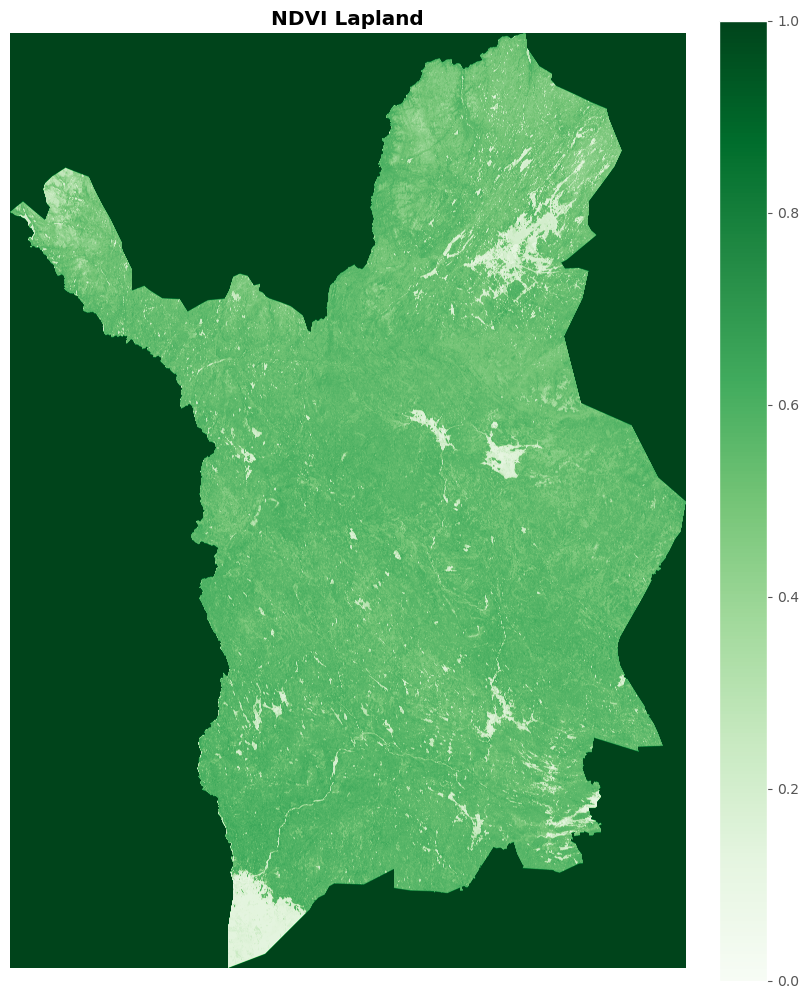

In [20]:
fig, ax = plt.subplots(figsize=(8, 10), layout='constrained')

# get path and open
source = 'input_data/ndvi_max_2021_lapland.tif'
img = rasterio.open(source)

# fig
show(img.read(), title='NDVI Lapland', cmap='Greens', ax=ax);

# colorbar
cmap = plt.cm.Greens

fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), 
             ax=ax, 
            )

plt.axis('off');

## Land Use Class frequency visualization

Let's take a look at the frequency of Land Use Classes in our selected province. The column we will use is the `LCluokka`

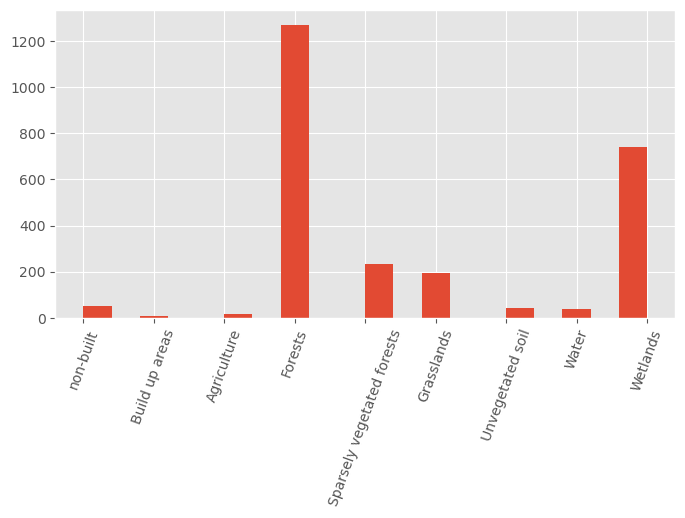

In [21]:
# Land Use class
lucas2018_lapland.LCluokka.hist(figsize=(8, 4), bins=20)

plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8],
            labels=['non-built', 'Build up areas', 'Agriculture', 'Forests', 
                    'Sparsely vegetated forests', 'Grasslands',
                    'Unvegetated soil', 'Water', 'Wetlands'],
          rotation=70
          );
    

## Create a datacube

A datacube is a structure that keeps many layers of information gathered in a three-dimensional (cubic) form. The x and y axis represents the location of data and every location can store many variables, and the z dimension represents temporal layers. This format is used mainly with environment or Earth Observation data.

We will add our variables to a datacube. Let's get familiar with the next functions.

In [22]:
def load_raster(raster, band_name):
    '''
    Gives back a raster with an specific band name
    '''
    
    # read
    xds = rxr.open_rasterio(raster)

    name = raster.split('/')[-1].split('.')[0]

    print(f'Loading - {name}')

    return xds.rename(band_name)


def create_cube(input_rasters):
    '''
    Gives back a data cube and a list of band names
    
    NOTE! 
    This function uses delayed functions from Dask
    '''
    
    # Raster input data for sampling
    rasters =  [path for path in input_rasters]
    
    band_names = [name.split('/')[-1].split('.')[0] for name in input_rasters]
    
    # delayed_rasters = [
    #     dask.delayed(load_raster)(raster, band_names[i]) for i, raster in enumerate(rasters)
    #                   ]   
    
    # rasters_to_merge = dask.compute(*delayed_rasters)

    rasters_to_merge = [load_raster(raster, band_names[i]) for i, raster in enumerate(rasters)]

    print(f'Merging...')
    
    cube = xr.merge(rasters_to_merge)

    print(f'Transposing...')
    
    cube = cube.transpose('band', 'y', 'x')

    print(f'Done!')
    
    return cube, band_names

In [23]:
raster_paths

['/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/canopy_cover_lapland.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/ndvi_max_2021_lapland.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/vegetation_height_lapland.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/s2_rgb_lapland_band1.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/s2_rgb_lapland_band3.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/s2_nir_lapland.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/tree_classes_lapland.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/s2_rgb_lapland_band2.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/input_data/km2_lapland.tif']

In [24]:
%%time

cube, band_names = create_cube(raster_paths)

Loading - canopy_cover_lapland
Loading - ndvi_max_2021_lapland
Loading - vegetation_height_lapland
Loading - s2_rgb_lapland_band1
Loading - s2_rgb_lapland_band3
Loading - s2_nir_lapland
Loading - tree_classes_lapland
Loading - s2_rgb_lapland_band2
Loading - km2_lapland
Merging...
Transposing...
Done!
CPU times: user 191 ms, sys: 48.9 ms, total: 240 ms
Wall time: 2.28 s


In [25]:
cube

<xarray.Dataset> Size: 33GB
Dimensions:                    (band: 1, x: 38477, y: 53241)
Coordinates:
  * band                       (band) int64 8B 1
  * x                          (x) float64 308kB 2.431e+05 ... 6.279e+05
  * y                          (y) float64 426kB 7.776e+06 ... 7.244e+06
    spatial_ref                int64 8B 0
Data variables:
    canopy_cover_lapland       (band, y, x) uint8 2GB ...
    ndvi_max_2021_lapland      (band, y, x) uint8 2GB ...
    vegetation_height_lapland  (band, y, x) uint8 2GB ...
    s2_rgb_lapland_band1       (band, y, x) uint16 4GB ...
    s2_rgb_lapland_band3       (band, y, x) uint16 4GB ...
    s2_nir_lapland             (band, y, x) uint16 4GB ...
    tree_classes_lapland       (band, y, x) uint8 2GB ...
    s2_rgb_lapland_band2       (band, y, x) uint16 4GB ...
    km2_lapland                (band, y, x) float32 8GB ...
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     127
    scale_factor:   1.0
    add_offset:     0.0

## Store bands for point-eo sampling script

We will keep the band names in a `band_names.txt` file for further use in our model.

In [26]:
band_name_file = os.path.join(basepth, 'band_names.txt')

with open(band_name_file, 'w') as fp:
    
    for item in band_names:
        
        fp.write("%s\n" % item)

## Sample raster using point-eo for sampling

In this process we are going to sample the raster data we have using the **Lucas 2018 dataset**. To use the **point-eo** tool we will use a parsing library called `argparse` that creates inputs variables while using scripts in terminal.

Follow the next process using the `sample_xarray` function from point-eo tool.

In [27]:
%%time

# -- paths
input_shape = os.path.join(home, 'training_data/lucas2018_19_lappi.shp')
output_sample_folder = os.path.join(basepth,'sampled')

# --  initiate parsing
parser = argparse.ArgumentParser()
subparsers = parser.add_subparsers(title="Available commands", dest="script")

# -- choose sampling xarrat - data cube
sample_xarray.add_args(subparsers)

# -- arguments
args = parser.parse_args(['sample_raster',
                            '--input', input_shape,
                            '--input_raster', 'dummy_placeholder',
                            '--target', 'LCluokka',
                            '--band_names', band_name_file,
                            '--out_folder', output_sample_folder])

# -- set input_raster to xarray variable - Data Cube
args.input_raster = cube

# -- RUN
sample_xarray.main(args)

Sampling xarray dataset using points from /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/training_data/lucas2018_19_lappi.shp
Using bandnames:
['canopy_cover_lapland',
 'ndvi_max_2021_lapland',
 'vegetation_height_lapland',
 's2_rgb_lapland_band1',
 's2_rgb_lapland_band3',
 's2_nir_lapland',
 'tree_classes_lapland',
 's2_rgb_lapland_band2',
 'km2_lapland']
Saved outputs to /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
CPU times: user 35.2 s, sys: 25.9 s, total: 1min 1s
Wall time: 3min 13s


In [28]:
# read sampling file
path = os.path.join(basepth,'sampled', 'xarray__lucas2018_19_lappi__LCluokka.csv')

df = pd.read_csv(path)

In [29]:
df.head()

,LCluokka,canopy_cover_lapland,ndvi_max_2021_lapland,vegetation_height_lapland,s2_rgb_lapland_band1,s2_rgb_lapland_band3,s2_nir_lapland,tree_classes_lapland,s2_rgb_lapland_band2,km2_lapland
0,6,127.0,112.0,255.0,1047.0,841.0,1500.0,30.0,977.0,859.72390
1,6,127.0,113.0,255.0,1135.0,995.0,1510.0,30.0,1103.0,778.58010
2,5,127.0,142.0,255.0,743.0,600.0,2150.0,30.0,730.0,699.85986
3,3,15.0,178.0,4.0,224.0,271.0,3281.0,11.0,423.0,197.96394
4,3,2.0,167.0,3.0,267.0,311.0,2159.0,11.0,429.0,151.15020


# Training with Random Forest model

Let's continue training our model using **Random Forest** implemented in point-eo tool.

Input csv: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/sampled/xarray__lucas2018_19_lappi__LCluokka.csv
Model: RF


### Data info ###

Columns. First one is chosen as target
Index		Column
0		LCluokka
1		canopy_cover_lapland
2		ndvi_max_2021_lapland
3		vegetation_height_lapland
4		s2_rgb_lapland_band1
5		s2_rgb_lapland_band3
6		s2_nir_lapland
7		tree_classes_lapland
8		s2_rgb_lapland_band2
9		km2_lapland


Shape of data table:
rows: 2598
columns: 10

Target class distribution
label	count
LCluokka
3    1271
8     741
4     235
5     194
0      52
6      42
7      38
2      17
1       8
Name: count, dtype: int64




### Starting cross-validation ###

Random forest parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None

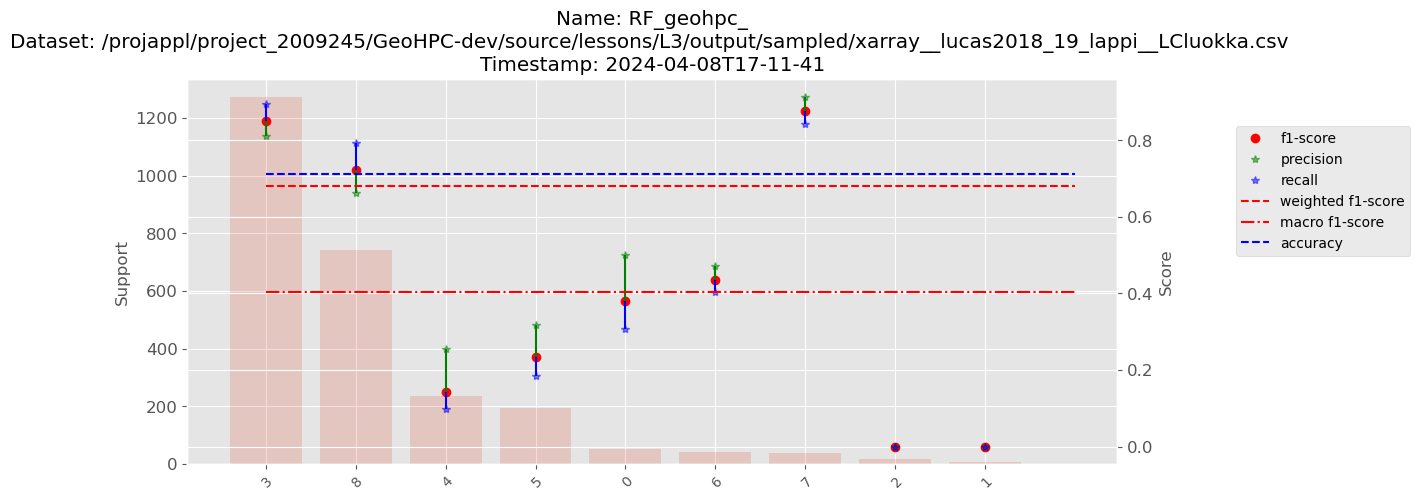

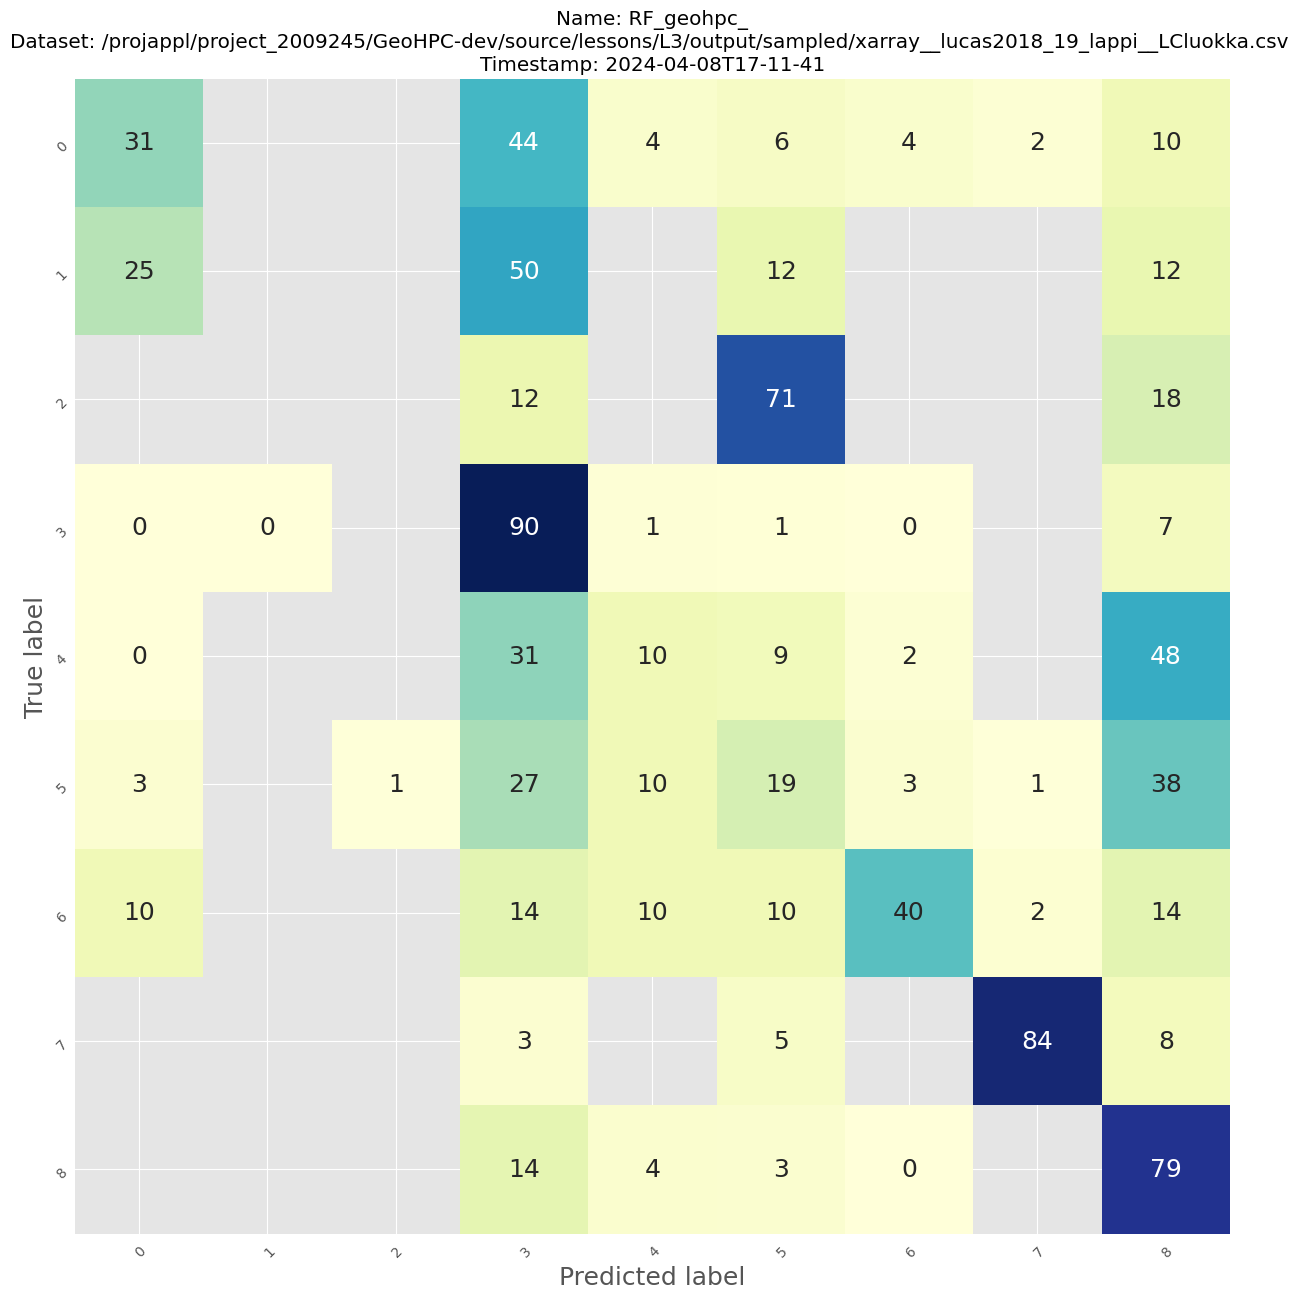

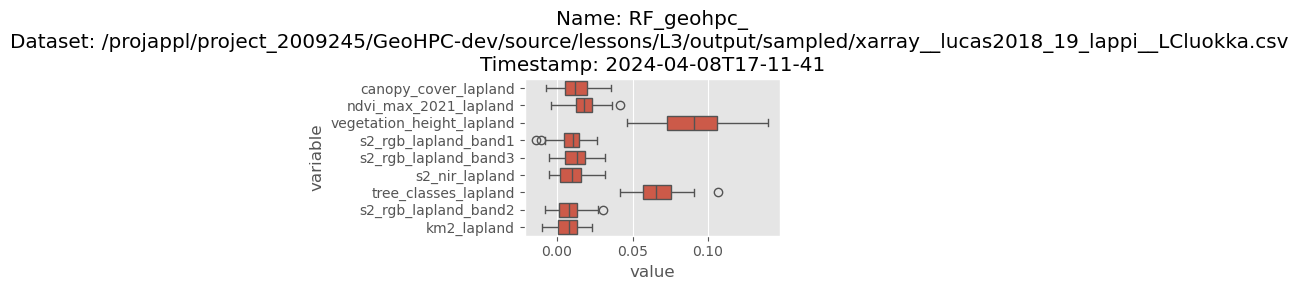

In [30]:
#  Training, analysis with the defaults (Random Forest)

# -- paths
input_sampling_file = os.path.join(basepth,'sampled','xarray__lucas2018_19_lappi__LCluokka.csv')
rf_folder = os.path.join(basepth,'model_fitting_RF')


# -- start parser
parser = argparse.ArgumentParser()
subparsers = parser.add_subparsers(title="Available commands", dest="script")
analysis.add_args(subparsers)

# -- arguments
args = parser.parse_args(['analysis',
                            '--input', input_sampling_file,
                            '--out_folder', rf_folder,
                            '--out_prefix', 'RF_geohpc_',
                            '--decimal', '.',
                            '--separator',','])

# -- RUN
analysis.main(args)

# Parallelization of Random Forest

![grid](img/Grid.png)

## Grid creation

We have a quite large area of the province so we are going to create grids that allow us to parallelize the process using each square. Follow step by step about the grid creation and the Land Use Class prediction with Random Forest.

Get familiar with the next function.

In [31]:
def create_grid(study_area, grid_size_m):
    '''
    Give back a Geodataframe with specific grid size based on study area
        study_area: geodaframe. default point geometry. crs not geographic
        grid_size_m: size of grid side in meters

        return: Geodataframe of polygons. Grid
    '''
    print(f'CRS of study area: {study_area.crs.name}')
    
    # get bounds of province
    xmin, ymin, xmax, ymax = study_area.buffer(100).total_bounds

    # grid size
    length = grid_size_m
    wide = grid_size_m

    cols = list(np.arange(xmin, xmax + wide, wide))
    rows = list(np.arange(ymin, ymax + length, length))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))
    
    grid = gpd.GeoDataFrame({'geometry':polygons}, crs = study_area.crs)

    # ----- Remove empty grids

    index_true = []
    
    for row in grid.itertuples():

        # check if contains
        contains = study_area.intersects(row.geometry)
  
        if True in contains.unique():

            # catch index of grid that contains study area
            index_true.append(row.Index)

    # subset only valid grids
    grid_valid = grid.loc[grid.index.isin(index_true)]

    # reset index
    grid_valid = grid_valid.reset_index(drop=True)
    
    print(f'Total grids: {len(grid_valid)}')
    
    return grid_valid

In [32]:
# create grids
grid = create_grid(lucas2018_lapland, 60000)

CRS of study area: ETRS89 / TM35FIN(E,N)
Total grids: 42


In [33]:
# save grid
grid.to_file('output/grid.gpkg')

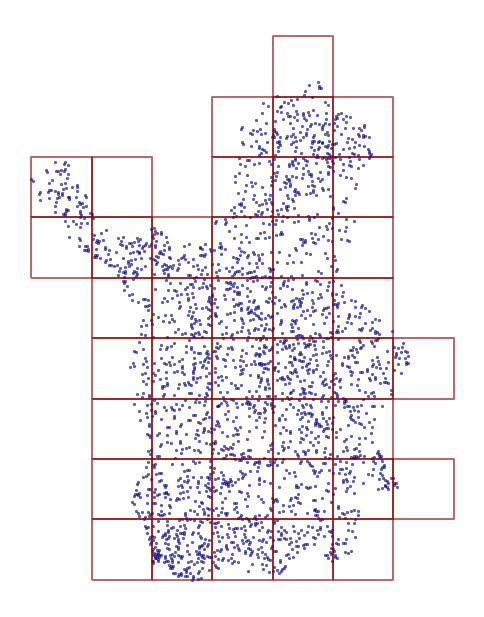

In [34]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(6, 8))

# plot
lucas2018_lapland.plot(ax=ax,
                       color='darkblue',
                       markersize= 3,
                       alpha = 0.6,
                      )

grid.plot(ax=ax,
          facecolor="none", 
          edgecolor="darkred",
          linewidth=1.4,
          alpha=0.6
         )

plt.axis('off');

## Automating Inference with Random Forest PointEO

We are going to pack the inference of Random Forest per area. The next function will use as input the fitted model, the independent grid, and some paths for results.

**Note**

We added a couple of lines in the function that remove intermediate files. We do it to save memory in the disk.


In [35]:
def run_random_forest(data_cube, grid_square, grid_index, output_folder = basepth):
    '''
    Run random forest using default PointEO parameters with Grid squares
        data_cube: data cube with input raster of the whole study area
        grid_square: geom 
        grid_index: n index of the grid for model prediction
    '''
    grid_index = '00'+ str(grid_index)
    grid_index = grid_index[-2:]

    # -- default filepaths

    # paths: model, predict folder
    
    model_path = glob.glob(os.path.join(basepth, f'model_fitting_RF', f'RF*LCluokka*{date.today()}*_model.pkl'))[0]
    print(f'Model: {model_path}')
    
    predict_folder = os.path.join(basepth, f'predict_output_RF_{grid_index}')
    resolution_file = os.path.join(basepth, f"out_RF_{grid_index}.vrt")
    postprocess_folder = os.path.join(basepth, f'land_use_results_RF')
    
    result_path = os.path.join(basepth, f'preprocess_RF_Grid-{grid_index}.tif')

    # --------------------------

    # --> if exists omit the grid cell

    ms_result = os.path.join(postprocess_folder, f'out_RF_{grid_index}_S.tif')
    
    if not os.path.exists(ms_result):
        
        # get bounds of grid
        xmin = grid_square.bounds[0]
        ymin = grid_square.bounds[1]
        xmax = grid_square.bounds[2]
        ymax = grid_square.bounds[3]
        
        # subset data cube
        Fx = cube.where((xmin < cube.x) 
                        & (cube.x < xmax)
                        & (ymin < cube.y) 
                        & (cube.y < ymax), drop=True).to_array().squeeze()
    
        # cell size of the interference blocks
        grid_cells = predict.create_cell_grid(Fx, 10000)
        
        # load rf-model from the analysis stem
        with open(model_path, "rb") as f:
            RF_model = pickle.load(f)
    
        # ----- predict Random Forest
    
        
        predict.calculate(model = RF_model,
                          Fx = Fx,
                          cell_list = grid_cells,
                          verbose=2,
                          out_folder = predict_folder)
    
        # combine blocks
        predict.merge_folder(predict_folder, resolution_file)
    
        # save as geotiff
        Rx = rxr.open_rasterio(
                                resolution_file,
                                chunks={"band": -1, "x": 2**10, "y": 2**10},
                                lock=False,
                                parallel=True,
                            )
    
        # save as tif
        Rx.rio.to_raster(result_path)
    
        # ----- Postprocess prediction
    
        # initiate parser
        parser = argparse.ArgumentParser()
        subparsers = parser.add_subparsers(title="Available commands", dest="script")
        postprocess_prediction.add_args(subparsers)
    
        # arguments
        args = parser.parse_args(['postprocess_prediction',
                                    '--input_raster', resolution_file,
                                    '--out_folder', postprocess_folder
                                    ])
    
        # run
        postprocess_prediction.main(args)

        # ---------------------------------------------------------- remove intermediate info for saving memory

        # folders
        folders = glob.glob(os.path.join(output_folder, '*output*'))
        
        for folder in folders:
        
            shutil.rmtree(folder)
        
        # files
        files = glob.glob(os.path.join(output_folder, '*.vrt'))
        
        for file in files:
        
            os.remove(file)

        pre_files = glob.glob(os.path.join(output_folder, 'preprocess*.tif'))
    
        for pre_file in pre_files:
    
            os.remove(pre_file)

    else:

        print(f'processed {ms_result}')


## Single grid square test

Let's check the model using only a single grid square from our grid.

In [36]:
s = time.time()

# test function with 1 grid square

grid_index = 1

# get geom
geom_grid = grid.at[grid_index, 'geometry']

# Run RF
run_random_forest(cube, geom_grid, grid_index);

single_time = time.time() - s

Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl
processed /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_01_S.tif


## Land Use prediction visualization

The results will be found in the `postprocess_folder` that we named `land_use_results_RF`. The file that contains the suffix **_S** is the one that contains the predicted land use. In this case the file is **out_RF_25_S.tif**

Let's check briefly the results for the **Grid-25**

![grid](img/Close-up.png)

## Create a Dask Client

To use the computational resources in Parallel we need to create a Dask Cluster using the Client function. You can read a bit more in the [Dask Documentation](https://docs.dask.org/en/stable/deploying-python.html). There is an extension for Jupyter Lab called `dask-labextension` that we installed in our environment. You will find a Dask logo in the left options bar of Jupyter Lab that will allow you to create a Cluster.
Simply, click on the `+ NEW` cluster, and then click on `< >` to add the client to the cell.

*Note*

You need to delete the code in the cell below and add a new client `tcp`. Like in Figure 1.

![img1](img/dask-img1.png)

Feel free to *Launch dashboard* in Jupyter Lab to see the performance of the supercomputer.

In [37]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37379")
client

<Client: 'tcp://127.0.0.1:37379' processes=4 threads=8, memory=32.00 GiB>

## Delayed functions

In Dask you can parallelize custom algorithms using the `dask.delayed` function. Not everything can fit in a Dask object so in this case the parallelization is sent as a function to the scheduler or cluster. 

We will use delayed functions for each grid square.

In [38]:
grid.head()

,geometry
0,"POLYGON ((249631.084 7580490.936, 309631.084 7..."
1,"POLYGON ((249631.084 7640490.936, 309631.084 7..."
2,"POLYGON ((309631.084 7280490.936, 369631.084 7..."
3,"POLYGON ((309631.084 7340490.936, 369631.084 7..."
4,"POLYGON ((309631.084 7400490.936, 369631.084 7..."


In [39]:
%%time

# create a list of delayed objects
delayed_RF_functions = [dask.delayed((run_random_forest)(cube, geom, i)) 
                        for i, geom in grid.itertuples()]

# run
with ProgressBar():
    dask.compute(delayed_RF_functions)

Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl
processed /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_00_S.tif
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl
processed /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_01_S.tif
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl
processed /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_02_S.tif
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl
processed /p

  2%|▏         | 1/49 [00:04<03:12,  4.01s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:05<02:05,  2.68s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:06<01:30,  1.96s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:07<01:13,  1.63s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:09<01:04,  1.47s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:10<00:58,  1.35s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:11<00:51,  1.22s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:15<01:28,  2.16s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:20<01:56,  2.92s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:24<02:12,  3.40s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:28<02:17,  3.61s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:32<02:18,  3.74s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:36<02:16,  3.80s/it]

SAVED 12


 29%|██▊       | 14/49 [00:37<01:42,  2.93s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:41<01:51,  3.29s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:45<01:57,  3.57s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:50<02:03,  3.85s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:54<02:00,  3.90s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:59<02:04,  4.16s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [01:03<02:01,  4.18s/it]

SAVED 19


 43%|████▎     | 21/49 [01:04<01:29,  3.21s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:08<01:34,  3.49s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:12<01:35,  3.66s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:16<01:34,  3.80s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:20<01:33,  3.89s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:24<01:30,  3.94s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:30<01:36,  4.41s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:31<01:10,  3.37s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:35<01:11,  3.57s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:39<01:10,  3.72s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:43<01:09,  3.86s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:47<01:06,  3.93s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:51<01:02,  3.93s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:55<00:58,  3.91s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:56<00:42,  3.02s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [02:00<00:43,  3.33s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [02:04<00:42,  3.52s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:08<00:42,  3.85s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:12<00:38,  3.86s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:16<00:34,  3.86s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:20<00:30,  3.87s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:21<00:20,  2.98s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:25<00:20,  3.34s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:29<00:17,  3.53s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:33<00:14,  3.68s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:37<00:11,  3.74s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:41<00:07,  3.82s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:45<00:03,  3.84s/it]

SAVED 47


100%|██████████| 49/49 [02:46<00:00,  3.40s/it]

NoDataInBounds in 48
Writing .vrt file...


0...10...20...30...40...50...60...70...80...90..

CPLE_NotSupported in driver VRT does not support open option PARALLEL


.100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:54,  1.14s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:53,  1.14s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:52,  1.15s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:51,  1.15s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:51,  1.17s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:50,  1.17s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:08<00:47,  1.13s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:13<01:49,  2.67s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:17<02:03,  3.09s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:21<02:10,  3.35s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:27<02:32,  4.00s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:31<02:27,  3.98s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:35<02:23,  3.98s/it]

SAVED 12


 29%|██▊       | 14/49 [00:36<01:47,  3.07s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:40<01:53,  3.34s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:44<01:56,  3.52s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:48<01:56,  3.64s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:52<01:56,  3.74s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:56<01:54,  3.82s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [01:00<01:55,  3.97s/it]

SAVED 19


 43%|████▎     | 21/49 [01:01<01:25,  3.07s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:05<01:30,  3.35s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:09<01:31,  3.52s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:13<01:31,  3.67s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:17<01:30,  3.79s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:21<01:28,  3.86s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:25<01:26,  3.92s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:26<01:03,  3.02s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:30<01:06,  3.34s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:34<01:06,  3.52s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:38<01:05,  3.65s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:42<01:03,  3.71s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:46<01:00,  3.80s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:50<00:57,  3.82s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:51<00:41,  2.95s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:54<00:42,  3.25s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:59<00:42,  3.54s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:03<00:40,  3.69s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:07<00:37,  3.77s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:11<00:34,  3.82s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:14<00:30,  3.83s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:15<00:20,  2.95s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:19<00:19,  3.23s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:24<00:18,  3.70s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:28<00:15,  3.82s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:32<00:11,  3.86s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:36<00:07,  3.87s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:40<00:03,  3.87s/it]

SAVED 47


100%|██████████| 49/49 [02:41<00:00,  3.29s/it]

NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.



CPLE_NotSupported in driver VRT does not support open option PARALLEL
CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:56,  1.17s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:55,  1.18s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:53,  1.16s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:51,  1.15s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:50,  1.14s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:49,  1.15s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:44,  1.06s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:19,  1.94s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:40,  2.51s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<01:56,  2.97s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:05,  3.29s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:27<02:08,  3.47s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:31<02:08,  3.57s/it]

SAVED 12


 29%|██▊       | 14/49 [00:31<01:36,  2.75s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:35<01:45,  3.12s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:39<01:50,  3.35s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:43<01:52,  3.51s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:48<02:01,  3.91s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:52<01:59,  3.98s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:56<01:55,  3.97s/it]

SAVED 19


 43%|████▎     | 21/49 [00:57<01:25,  3.05s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:01<01:29,  3.32s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:05<01:31,  3.51s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:09<01:31,  3.67s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:13<01:30,  3.78s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:17<01:28,  3.85s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:21<01:26,  3.92s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:22<01:03,  3.03s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:26<01:06,  3.32s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:30<01:06,  3.51s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:34<01:06,  3.67s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:38<01:04,  3.80s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:42<01:02,  3.91s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:46<00:59,  3.96s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:47<00:42,  3.06s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:52<00:44,  3.45s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:56<00:43,  3.63s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:00<00:41,  3.76s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:04<00:38,  3.84s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:08<00:34,  3.88s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:12<00:31,  3.90s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:13<00:21,  3.01s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:17<00:19,  3.32s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:21<00:17,  3.54s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:25<00:14,  3.69s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:29<00:11,  3.78s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:33<00:07,  3.86s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:37<00:03,  3.90s/it]

SAVED 47


100%|██████████| 49/49 [02:38<00:00,  3.23s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:54,  1.14s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:54,  1.16s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:52,  1.15s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:51,  1.15s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:50,  1.14s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:49,  1.15s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:45,  1.09s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:24,  2.06s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:16<01:49,  2.75s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:20<02:05,  3.22s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:24<02:13,  3.50s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:28<02:14,  3.63s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:32<02:15,  3.78s/it]

SAVED 12


 29%|██▊       | 14/49 [00:33<01:42,  2.93s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:37<01:52,  3.29s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:41<01:57,  3.55s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:46<02:01,  3.78s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:50<02:00,  3.87s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:54<01:57,  3.92s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:58<01:54,  3.96s/it]

SAVED 19


 43%|████▎     | 21/49 [00:59<01:25,  3.06s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:03<01:30,  3.36s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:07<01:32,  3.57s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:11<01:33,  3.72s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:15<01:33,  3.89s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:19<01:30,  3.94s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:23<01:27,  3.97s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:24<01:04,  3.07s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:29<01:08,  3.44s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:33<01:08,  3.60s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:37<01:06,  3.72s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:41<01:04,  3.79s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:45<01:02,  3.91s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:49<00:58,  3.93s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:50<00:42,  3.03s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:54<00:43,  3.37s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:58<00:43,  3.61s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:02<00:41,  3.74s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:06<00:38,  3.85s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:10<00:35,  3.93s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:15<00:32,  4.00s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:16<00:21,  3.09s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:20<00:20,  3.38s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:24<00:17,  3.59s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:28<00:14,  3.73s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:32<00:11,  3.83s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:36<00:07,  3.88s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:40<00:03,  3.93s/it]

SAVED 47


100%|██████████| 49/49 [02:41<00:00,  3.29s/it]

NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90..

.100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:54,  1.14s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:53,  1.14s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:52,  1.15s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:52,  1.16s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:51,  1.17s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:07<00:50,  1.18s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:46,  1.11s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:12<01:25,  2.08s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:16<01:48,  2.71s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:20<02:09,  3.33s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:24<02:13,  3.52s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:29<02:16,  3.70s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:33<02:16,  3.79s/it]

SAVED 12


 29%|██▊       | 14/49 [00:33<01:42,  2.94s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:38<01:51,  3.29s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:41<01:54,  3.47s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:45<01:53,  3.56s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:49<01:52,  3.62s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:53<01:50,  3.69s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:57<01:47,  3.70s/it]

SAVED 19


 43%|████▎     | 21/49 [00:57<01:20,  2.87s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:01<01:25,  3.16s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:05<01:28,  3.40s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:09<01:29,  3.56s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:13<01:27,  3.65s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:17<01:26,  3.75s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:21<01:24,  3.85s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:22<01:02,  2.97s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:26<01:06,  3.31s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:30<01:07,  3.54s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:34<01:06,  3.67s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:38<01:04,  3.79s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:43<01:02,  3.92s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:47<00:59,  3.96s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:48<00:42,  3.06s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:52<00:44,  3.41s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:56<00:43,  3.66s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:00<00:41,  3.79s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:04<00:39,  3.91s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:08<00:35,  3.98s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:12<00:31,  3.99s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:13<00:21,  3.11s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:18<00:20,  3.45s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:22<00:18,  3.72s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:26<00:15,  3.82s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:30<00:11,  3.92s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:34<00:07,  3.98s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:38<00:04,  4.01s/it]

SAVED 47


100%|██████████| 49/49 [02:39<00:00,  3.26s/it]

NoDataInBounds in 48
Writing .vrt file...



CPLE_NotSupported in driver VRT does not support open option PARALLEL


0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:54,  1.14s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:53,  1.14s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:52,  1.14s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:50,  1.13s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:48,  1.11s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:47,  1.11s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:43,  1.04s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:21,  1.98s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:42,  2.57s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<01:54,  2.94s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:01,  3.20s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:26<02:05,  3.39s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:30<02:06,  3.51s/it]

SAVED 12


 29%|██▊       | 14/49 [00:31<01:35,  2.73s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:35<01:45,  3.09s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:39<01:51,  3.38s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:43<01:53,  3.56s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:47<01:52,  3.63s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:51<01:51,  3.72s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:55<01:49,  3.78s/it]

SAVED 19


 43%|████▎     | 21/49 [00:56<01:21,  2.91s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [00:59<01:26,  3.20s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:03<01:28,  3.40s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:07<01:28,  3.55s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:11<01:27,  3.63s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:15<01:25,  3.70s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:19<01:23,  3.80s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:20<01:01,  2.94s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:24<01:04,  3.23s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:28<01:05,  3.44s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:32<01:05,  3.63s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:36<01:03,  3.71s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:40<01:01,  3.83s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:44<00:58,  3.89s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:45<00:42,  3.00s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:49<00:43,  3.32s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:53<00:42,  3.51s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [01:57<00:40,  3.70s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:01<00:37,  3.78s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:05<00:34,  3.83s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:09<00:31,  3.91s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:10<00:21,  3.02s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:14<00:19,  3.28s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:18<00:17,  3.46s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:22<00:14,  3.61s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:26<00:11,  3.71s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:30<00:07,  3.80s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:34<00:03,  3.86s/it]

SAVED 47


100%|██████████| 49/49 [02:34<00:00,  3.16s/it]

NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80..


CPLE_NotSupported in driver VRT does not support open option PARALLEL


.90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:54,  1.14s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:53,  1.14s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:52,  1.15s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:50,  1.13s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:48,  1.11s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:47,  1.10s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:43,  1.04s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:24,  2.05s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:46,  2.66s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<02:00,  3.08s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:08,  3.39s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:28<02:13,  3.60s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:32<02:15,  3.76s/it]

SAVED 12


 29%|██▊       | 14/49 [00:33<01:41,  2.91s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:37<01:51,  3.29s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:41<01:58,  3.59s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:45<01:59,  3.72s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:49<01:58,  3.81s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:53<01:55,  3.86s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:57<01:53,  3.92s/it]

SAVED 19


 43%|████▎     | 21/49 [00:58<01:25,  3.04s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:02<01:30,  3.37s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:06<01:32,  3.57s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:11<01:34,  3.79s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:15<01:33,  3.91s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:19<01:30,  3.92s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:23<01:25,  3.90s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:23<01:02,  2.99s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:28<01:06,  3.31s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:32<01:06,  3.53s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:36<01:05,  3.66s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:40<01:03,  3.76s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:44<01:01,  3.83s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:47<00:57,  3.86s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:48<00:41,  2.97s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:52<00:42,  3.28s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:56<00:41,  3.46s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:00<00:39,  3.59s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:04<00:36,  3.68s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:08<00:33,  3.75s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:12<00:31,  3.89s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:13<00:20,  3.00s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:17<00:19,  3.32s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:21<00:17,  3.53s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:25<00:14,  3.65s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:29<00:11,  3.75s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:33<00:07,  3.84s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:37<00:03,  3.88s/it]

SAVED 47


100%|██████████| 49/49 [02:38<00:00,  3.23s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:55,  1.15s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:53,  1.14s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:51,  1.11s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:50,  1.12s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:48,  1.11s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:47,  1.10s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:43,  1.04s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:17,  1.90s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:14<01:37,  2.43s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:18<01:49,  2.80s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:22<01:57,  3.09s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:26<02:01,  3.28s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:29<02:02,  3.41s/it]

SAVED 12


 29%|██▊       | 14/49 [00:30<01:33,  2.66s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:34<01:43,  3.03s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:38<01:46,  3.23s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:41<01:47,  3.35s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:45<01:46,  3.43s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:49<01:44,  3.48s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:52<01:42,  3.52s/it]

SAVED 19


 43%|████▎     | 21/49 [00:53<01:16,  2.73s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [00:57<01:22,  3.07s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:01<01:26,  3.31s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:05<01:27,  3.50s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:09<01:27,  3.64s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:13<01:25,  3.73s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:17<01:23,  3.80s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:18<01:01,  2.94s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:22<01:05,  3.28s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:26<01:06,  3.52s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:30<01:06,  3.69s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:34<01:04,  3.81s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:38<01:01,  3.87s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:42<00:59,  3.95s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:43<00:42,  3.07s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:47<00:43,  3.34s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:51<00:42,  3.54s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [01:55<00:40,  3.68s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [01:59<00:37,  3.78s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:03<00:35,  3.95s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:08<00:32,  4.02s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:09<00:21,  3.11s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:13<00:20,  3.42s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:17<00:18,  3.64s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:21<00:15,  3.81s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:25<00:11,  3.89s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:29<00:07,  3.97s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:33<00:03,  3.99s/it]

SAVED 47


100%|██████████| 49/49 [02:34<00:00,  3.16s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:52,  1.10s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:51,  1.10s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:50,  1.09s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:49,  1.09s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:47,  1.08s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:45,  1.07s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:42,  1.02s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:16,  1.86s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:14<01:36,  2.41s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:18<01:50,  2.83s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:22<01:57,  3.10s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:25<02:03,  3.32s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:29<02:04,  3.45s/it]

SAVED 12


 29%|██▊       | 14/49 [00:30<01:34,  2.69s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:34<01:44,  3.08s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:38<01:48,  3.27s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:42<01:49,  3.42s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:45<01:49,  3.54s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:49<01:48,  3.60s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:53<01:45,  3.65s/it]

SAVED 19


 43%|████▎     | 21/49 [00:54<01:19,  2.83s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [00:58<01:26,  3.19s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:02<01:29,  3.43s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:06<01:30,  3.61s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:10<01:29,  3.72s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:14<01:27,  3.79s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:18<01:24,  3.86s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:19<01:03,  3.00s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:23<01:07,  3.38s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:27<01:08,  3.59s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:31<01:07,  3.74s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:36<01:06,  3.90s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:40<01:02,  3.92s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:44<00:59,  3.96s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:45<00:43,  3.10s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:49<00:44,  3.42s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:53<00:42,  3.54s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [01:56<00:39,  3.61s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:00<00:36,  3.64s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:04<00:33,  3.72s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:08<00:29,  3.70s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:09<00:20,  2.87s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:13<00:19,  3.19s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:16<00:16,  3.39s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:20<00:14,  3.51s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:24<00:10,  3.60s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:28<00:07,  3.66s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:32<00:03,  3.68s/it]

SAVED 47


100%|██████████| 49/49 [02:32<00:00,  3.12s/it]

NoDataInBounds in 48
Writing .vrt file...



CPLE_NotSupported in driver VRT does not support open option PARALLEL


0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:52,  1.09s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:52,  1.11s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:51,  1.12s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:50,  1.13s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:49,  1.12s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:47,  1.12s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:44,  1.05s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:19,  1.94s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:41,  2.55s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<01:57,  3.02s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:05,  3.31s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:29<02:30,  4.08s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:33<02:24,  4.02s/it]

SAVED 12


 29%|██▊       | 14/49 [00:34<01:47,  3.08s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:37<01:53,  3.33s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:41<01:56,  3.52s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:45<01:57,  3.67s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:49<01:57,  3.80s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:53<01:54,  3.82s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:57<01:51,  3.85s/it]

SAVED 19


 43%|████▎     | 21/49 [00:58<01:23,  2.98s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:02<01:26,  3.22s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:06<01:28,  3.39s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:10<01:28,  3.52s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:13<01:26,  3.62s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:18<01:26,  3.76s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:21<01:23,  3.81s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:22<01:01,  2.94s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:26<01:04,  3.22s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:30<01:04,  3.40s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:34<01:03,  3.55s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:38<01:02,  3.66s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:42<00:59,  3.74s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:46<00:59,  3.94s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:47<00:42,  3.05s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:51<00:41,  3.23s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:55<00:40,  3.37s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [01:58<00:38,  3.48s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:02<00:35,  3.55s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:06<00:32,  3.62s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:10<00:29,  3.67s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:11<00:19,  2.84s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:14<00:18,  3.09s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:18<00:16,  3.24s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:22<00:13,  3.40s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:26<00:11,  3.68s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:30<00:07,  3.81s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:34<00:03,  3.78s/it]

SAVED 47


100%|██████████| 49/49 [02:35<00:00,  3.17s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:55,  1.15s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:53,  1.15s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:53,  1.16s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:52,  1.16s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:50,  1.15s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:49,  1.14s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:45,  1.08s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:20,  1.95s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:42,  2.55s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<01:55,  2.95s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:02,  3.23s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:27<02:07,  3.46s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:31<02:09,  3.59s/it]

SAVED 12


 29%|██▊       | 14/49 [00:32<01:37,  2.79s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:35<01:45,  3.09s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:39<01:49,  3.32s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:43<01:49,  3.43s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:47<01:49,  3.55s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:51<01:49,  3.66s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:55<01:49,  3.77s/it]

SAVED 19


 43%|████▎     | 21/49 [00:56<01:21,  2.93s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:00<01:28,  3.28s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:04<01:31,  3.52s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:08<01:31,  3.66s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:12<01:30,  3.77s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:16<01:29,  3.88s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:21<01:30,  4.10s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:22<01:06,  3.18s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:26<01:09,  3.48s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:30<01:10,  3.70s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:34<01:08,  3.78s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:38<01:05,  3.87s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:42<01:03,  3.96s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:46<00:59,  3.99s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:47<00:43,  3.11s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:52<00:44,  3.44s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:56<00:43,  3.66s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:00<00:41,  3.78s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:04<00:38,  3.88s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:08<00:35,  3.93s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:12<00:31,  3.93s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:13<00:21,  3.04s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:17<00:20,  3.38s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:21<00:17,  3.58s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:25<00:14,  3.68s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:29<00:11,  3.73s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:33<00:07,  3.79s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:37<00:03,  3.81s/it]

SAVED 47


100%|██████████| 49/49 [02:38<00:00,  3.23s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:54,  1.14s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:54,  1.16s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:53,  1.15s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:51,  1.15s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:50,  1.15s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:49,  1.14s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:45,  1.09s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:23,  2.04s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:46,  2.67s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:20<02:00,  3.09s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:24<02:09,  3.40s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:28<02:12,  3.57s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:32<02:13,  3.70s/it]

SAVED 12


 29%|██▊       | 14/49 [00:33<01:39,  2.86s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:36<01:48,  3.20s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:41<01:54,  3.46s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:45<01:57,  3.66s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:49<01:56,  3.77s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:53<01:56,  3.89s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:57<01:53,  3.90s/it]

SAVED 19


 43%|████▎     | 21/49 [00:58<01:24,  3.01s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:02<01:30,  3.35s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:06<01:32,  3.56s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:10<01:33,  3.74s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:14<01:32,  3.85s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:18<01:30,  3.93s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:23<01:28,  4.01s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:24<01:05,  3.11s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:28<01:08,  3.41s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:32<01:08,  3.59s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:36<01:07,  3.76s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:40<01:05,  3.87s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:44<01:02,  3.93s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:48<00:59,  3.97s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:49<00:42,  3.05s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:53<00:44,  3.40s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:57<00:43,  3.59s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:01<00:40,  3.72s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:05<00:37,  3.80s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:09<00:34,  3.83s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:13<00:30,  3.87s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:14<00:20,  2.99s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:18<00:20,  3.34s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:22<00:17,  3.57s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:26<00:14,  3.72s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:30<00:11,  3.85s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:35<00:07,  3.92s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:39<00:04,  4.04s/it]

SAVED 47


100%|██████████| 49/49 [02:40<00:00,  3.27s/it]

NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90..


CPLE_NotSupported in driver VRT does not support open option PARALLEL


.100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:54,  1.13s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:54,  1.16s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:53,  1.16s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:52,  1.16s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:50,  1.15s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:07<00:55,  1.29s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:08<00:49,  1.18s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:12<01:27,  2.13s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:16<01:47,  2.68s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:20<01:59,  3.06s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:24<02:07,  3.35s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:28<02:10,  3.54s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:32<02:10,  3.63s/it]

SAVED 12


 29%|██▊       | 14/49 [00:33<01:38,  2.82s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:36<01:47,  3.16s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:40<01:52,  3.40s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:44<01:53,  3.55s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:48<01:53,  3.65s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:52<01:50,  3.68s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:56<01:48,  3.73s/it]

SAVED 19


 43%|████▎     | 21/49 [00:57<01:20,  2.89s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:01<01:26,  3.19s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:05<01:28,  3.41s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:09<01:29,  3.59s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:12<01:27,  3.65s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:16<01:24,  3.69s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:20<01:22,  3.74s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:21<01:00,  2.90s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:25<01:04,  3.22s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:29<01:04,  3.42s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:33<01:03,  3.55s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:36<01:01,  3.64s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:40<00:59,  3.71s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:44<00:56,  3.74s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:45<00:40,  2.89s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:49<00:41,  3.18s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:53<00:41,  3.43s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [01:57<00:39,  3.59s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:01<00:37,  3.72s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:05<00:34,  3.80s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:09<00:31,  3.91s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:10<00:21,  3.02s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:14<00:20,  3.34s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:18<00:17,  3.54s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:22<00:14,  3.71s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:26<00:11,  3.82s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:30<00:07,  3.91s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:35<00:03,  4.00s/it]

SAVED 47


100%|██████████| 49/49 [02:36<00:00,  3.19s/it]

NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.



CPLE_NotSupported in driver VRT does not support open option PARALLEL
CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:54,  1.13s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:52,  1.13s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:51,  1.12s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:50,  1.12s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:49,  1.12s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:47,  1.12s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:44,  1.05s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:19,  1.95s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:41,  2.53s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<01:54,  2.93s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:22<02:02,  3.22s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:27<02:12,  3.58s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:31<02:10,  3.64s/it]

SAVED 12


 29%|██▊       | 14/49 [00:32<01:38,  2.82s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:35<01:46,  3.14s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:39<01:51,  3.36s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:43<01:51,  3.49s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:47<01:52,  3.63s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:51<01:51,  3.71s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:55<01:50,  3.79s/it]

SAVED 19


 43%|████▎     | 21/49 [00:56<01:21,  2.93s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:00<01:27,  3.22s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:04<01:29,  3.43s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:08<01:29,  3.58s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:12<01:28,  3.70s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:16<01:26,  3.76s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:20<01:24,  3.84s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:20<01:02,  2.96s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:25<01:06,  3.31s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:28<01:05,  3.47s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:33<01:05,  3.65s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:37<01:04,  3.77s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:41<01:01,  3.83s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:45<00:58,  3.89s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:46<00:42,  3.02s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:50<00:43,  3.36s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:54<00:43,  3.60s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [01:58<00:41,  3.75s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:02<00:38,  3.87s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:06<00:35,  3.93s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:10<00:32,  4.00s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:11<00:21,  3.10s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:15<00:19,  3.33s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:19<00:17,  3.51s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:23<00:14,  3.68s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:27<00:11,  3.74s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:31<00:07,  3.84s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:35<00:03,  3.86s/it]

SAVED 47


100%|██████████| 49/49 [02:36<00:00,  3.19s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:54,  1.14s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:53,  1.14s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:52,  1.13s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:50,  1.13s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:49,  1.12s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:47,  1.10s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:43,  1.03s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:21,  1.98s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:47,  2.68s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<02:00,  3.10s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:08,  3.38s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:27<02:12,  3.58s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:31<02:13,  3.71s/it]

SAVED 12


 29%|██▊       | 14/49 [00:32<01:40,  2.88s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:37<01:51,  3.27s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:41<01:56,  3.52s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:45<02:00,  3.77s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:49<02:00,  3.87s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:53<01:58,  3.96s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:57<01:56,  4.01s/it]

SAVED 19


 43%|████▎     | 21/49 [00:58<01:26,  3.10s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:03<01:33,  3.48s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:07<01:36,  3.69s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:11<01:35,  3.81s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:15<01:34,  3.95s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:19<01:31,  3.98s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:23<01:28,  4.01s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:24<01:04,  3.09s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:29<01:08,  3.43s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:33<01:09,  3.65s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:37<01:08,  3.78s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:41<01:05,  3.87s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:45<01:04,  4.03s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:49<01:01,  4.07s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:50<00:44,  3.15s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:55<00:45,  3.48s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:59<00:44,  3.69s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:03<00:42,  3.84s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:07<00:39,  3.95s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:11<00:36,  4.02s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:16<00:32,  4.11s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:17<00:22,  3.19s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:21<00:21,  3.52s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:25<00:18,  3.75s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:30<00:15,  3.92s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:34<00:11,  3.97s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:38<00:08,  4.01s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:42<00:04,  4.01s/it]

SAVED 47


100%|██████████| 49/49 [02:43<00:00,  3.34s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:54,  1.13s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:52,  1.11s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:54,  1.18s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:51,  1.15s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:49,  1.13s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:48,  1.13s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:45,  1.08s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:21,  1.99s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:41,  2.54s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<01:55,  2.96s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:02,  3.23s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:27<02:06,  3.42s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:30<02:07,  3.55s/it]

SAVED 12


 29%|██▊       | 14/49 [00:31<01:36,  2.75s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:35<01:45,  3.09s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:39<01:49,  3.32s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:43<01:51,  3.47s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:47<01:51,  3.60s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:51<01:50,  3.67s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:54<01:48,  3.73s/it]

SAVED 19


 43%|████▎     | 21/49 [00:55<01:21,  2.89s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [00:59<01:25,  3.16s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:03<01:28,  3.39s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:07<01:27,  3.52s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:11<01:26,  3.62s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:15<01:24,  3.69s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:18<01:21,  3.72s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:19<01:00,  2.90s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:23<01:04,  3.20s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:27<01:04,  3.37s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:31<01:03,  3.51s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:35<01:02,  3.65s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:39<00:59,  3.69s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:43<00:56,  3.74s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:44<00:40,  2.90s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:47<00:41,  3.18s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:51<00:40,  3.36s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [01:55<00:38,  3.47s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [01:59<00:36,  3.63s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:03<00:33,  3.74s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:07<00:30,  3.77s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:08<00:20,  2.91s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:11<00:19,  3.21s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:15<00:16,  3.38s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:19<00:14,  3.54s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:23<00:11,  3.68s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:27<00:07,  3.76s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:31<00:03,  3.85s/it]

SAVED 47


100%|██████████| 49/49 [02:32<00:00,  3.12s/it]

NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90..


CPLE_NotSupported in driver VRT does not support open option PARALLEL


.100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:53,  1.11s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:51,  1.10s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:50,  1.09s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:49,  1.09s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:50,  1.14s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:48,  1.13s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:44,  1.06s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:23,  2.03s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:46,  2.67s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<02:01,  3.11s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:24<02:09,  3.41s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:28<02:15,  3.65s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:32<02:16,  3.80s/it]

SAVED 12


 29%|██▊       | 14/49 [00:33<01:42,  2.93s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:37<01:54,  3.35s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:41<01:59,  3.64s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:45<02:00,  3.78s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:50<02:00,  3.89s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:54<01:58,  3.96s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:58<01:55,  3.99s/it]

SAVED 19


 43%|████▎     | 21/49 [00:59<01:26,  3.08s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:03<01:32,  3.41s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:07<01:35,  3.68s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:11<01:35,  3.84s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:16<01:34,  3.96s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:20<01:32,  4.02s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:24<01:28,  4.04s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:25<01:05,  3.12s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:29<01:09,  3.49s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:33<01:09,  3.67s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:38<01:10,  3.90s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:42<01:07,  4.00s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:46<01:05,  4.09s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:51<01:02,  4.14s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:52<00:44,  3.20s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:56<00:45,  3.52s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [02:02<00:50,  4.18s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:06<00:46,  4.24s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:10<00:41,  4.13s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:14<00:36,  4.08s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:18<00:32,  4.01s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:19<00:21,  3.08s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:22<00:19,  3.30s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:26<00:17,  3.43s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:30<00:14,  3.55s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:34<00:10,  3.64s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:38<00:07,  3.77s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:42<00:03,  3.78s/it]

SAVED 47


100%|██████████| 49/49 [02:43<00:00,  3.33s/it]

NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.



CPLE_NotSupported in driver VRT does not support open option PARALLEL
CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  5%|▍         | 1/21 [00:00<00:08,  2.49it/s]

NoDataInBounds in 0


 10%|▉         | 2/21 [00:00<00:07,  2.49it/s]

NoDataInBounds in 1


 14%|█▍        | 3/21 [00:01<00:05,  3.00it/s]

NoDataInBounds in 2


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 19%|█▉        | 4/21 [00:04<00:24,  1.45s/it]

SAVED 3


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 20.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 10.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 5/21 [00:06<00:26,  1.63s/it]

SAVED 4


 29%|██▊       | 6/21 [00:06<00:18,  1.22s/it]

NoDataInBounds in 5


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 7/21 [00:09<00:25,  1.84s/it]

SAVED 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 20.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 10.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 38%|███▊      | 8/21 [00:11<00:24,  1.87s/it]

SAVED 7


 43%|████▎     | 9/21 [00:11<00:16,  1.36s/it]

NoDataInBounds in 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 48%|████▊     | 10/21 [00:15<00:21,  1.92s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 20.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 10.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 52%|█████▏    | 11/21 [00:16<00:19,  1.93s/it]

SAVED 10


 57%|█████▋    | 12/21 [00:17<00:12,  1.42s/it]

NoDataInBounds in 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 62%|██████▏   | 13/21 [00:20<00:15,  1.94s/it]

SAVED 12


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 20.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 10.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 14/21 [00:22<00:13,  1.95s/it]

SAVED 13


 71%|███████▏  | 15/21 [00:22<00:08,  1.44s/it]

NoDataInBounds in 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 16/21 [00:25<00:09,  1.94s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 20.46 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 10.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 81%|████████  | 17/21 [00:27<00:07,  1.95s/it]

SAVED 16


 86%|████████▌ | 18/21 [00:27<00:04,  1.44s/it]

NoDataInBounds in 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|█████████ | 19/21 [00:31<00:03,  1.93s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 20.44 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 10.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 95%|█████████▌| 20/21 [00:32<00:01,  1.93s/it]

SAVED 19


100%|██████████| 21/21 [00:33<00:00,  1.58s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 20
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 18.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 18.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:56,  1.18s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:54,  1.15s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:52,  1.15s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:53,  1.20s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:51,  1.18s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:07<00:58,  1.35s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:08<00:50,  1.21s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:12<01:21,  1.98s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:42,  2.57s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<01:57,  3.01s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:04,  3.27s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:27<02:07,  3.44s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:31<02:08,  3.56s/it]

SAVED 12


 29%|██▊       | 14/49 [00:32<01:37,  2.77s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:36<01:46,  3.12s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:40<01:48,  3.30s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:43<01:50,  3.45s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:47<01:50,  3.57s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:51<01:48,  3.62s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:55<01:46,  3.68s/it]

SAVED 19


 43%|████▎     | 21/49 [00:56<01:20,  2.86s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [00:59<01:24,  3.11s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:03<01:25,  3.30s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:07<01:25,  3.42s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:11<01:24,  3.50s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:14<01:22,  3.57s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:18<01:19,  3.63s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:19<00:59,  2.83s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:23<01:02,  3.12s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:26<01:02,  3.28s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:30<01:01,  3.43s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:34<00:59,  3.51s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:38<00:57,  3.59s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:41<00:54,  3.63s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:42<00:39,  2.83s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:46<00:40,  3.12s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:50<00:39,  3.31s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [01:54<00:37,  3.44s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [01:57<00:35,  3.51s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:01<00:32,  3.56s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:05<00:29,  3.64s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:06<00:19,  2.84s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:10<00:18,  3.11s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:13<00:16,  3.29s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:17<00:13,  3.42s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:21<00:10,  3.51s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:24<00:07,  3.57s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:28<00:03,  3.61s/it]

SAVED 47


100%|██████████| 49/49 [02:29<00:00,  3.05s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:52,  1.09s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:51,  1.09s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:50,  1.10s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:49,  1.11s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:49,  1.12s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:48,  1.12s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:44,  1.06s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:23,  2.04s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:44,  2.62s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<01:58,  3.04s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:05,  3.30s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:27<02:08,  3.46s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:31<02:08,  3.58s/it]

SAVED 12


 29%|██▊       | 14/49 [00:32<01:37,  2.78s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:36<01:46,  3.14s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:40<01:52,  3.41s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:43<01:53,  3.54s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:47<01:52,  3.62s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:51<01:51,  3.71s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:55<01:48,  3.75s/it]

SAVED 19


 43%|████▎     | 21/49 [00:56<01:20,  2.89s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:00<01:26,  3.20s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:04<01:27,  3.37s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:08<01:28,  3.53s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:11<01:27,  3.65s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:16<01:27,  3.79s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:20<01:25,  3.90s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:21<01:03,  3.02s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:25<01:05,  3.28s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:28<01:05,  3.47s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:32<01:04,  3.59s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:36<01:03,  3.71s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:40<01:01,  3.84s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:45<00:58,  3.89s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:45<00:42,  3.01s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:49<00:42,  3.28s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:53<00:41,  3.46s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [01:57<00:39,  3.58s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:01<00:36,  3.69s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:05<00:33,  3.76s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:09<00:30,  3.86s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:10<00:20,  2.97s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:14<00:19,  3.23s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:18<00:17,  3.40s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:22<00:14,  3.56s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:26<00:11,  3.68s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:30<00:07,  3.79s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:34<00:03,  3.85s/it]

SAVED 47


100%|██████████| 49/49 [02:34<00:00,  3.16s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:53,  1.11s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:51,  1.10s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:51,  1.11s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:50,  1.11s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:49,  1.12s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:48,  1.13s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:44,  1.05s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:21,  1.99s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:45,  2.63s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<02:02,  3.14s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:24<02:12,  3.49s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:28<02:16,  3.68s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:32<02:16,  3.79s/it]

SAVED 12


 29%|██▊       | 14/49 [00:33<01:43,  2.96s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:37<01:54,  3.37s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:41<01:59,  3.62s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:46<02:02,  3.83s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:50<02:00,  3.90s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:54<01:58,  3.95s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:58<01:54,  3.96s/it]

SAVED 19


 43%|████▎     | 21/49 [00:59<01:25,  3.04s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:03<01:30,  3.36s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:07<01:32,  3.57s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:11<01:32,  3.72s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:15<01:32,  3.84s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:19<01:30,  3.92s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:23<01:26,  3.94s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:24<01:03,  3.03s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:28<01:07,  3.36s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:32<01:07,  3.57s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:36<01:06,  3.72s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:40<01:04,  3.82s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:45<01:02,  3.90s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:49<01:00,  4.02s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:50<00:43,  3.11s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:54<00:44,  3.43s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:58<00:43,  3.61s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:02<00:41,  3.76s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:06<00:38,  3.85s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:10<00:35,  3.95s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:15<00:32,  4.12s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:16<00:22,  3.18s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:20<00:20,  3.44s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:24<00:17,  3.58s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:28<00:14,  3.70s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:32<00:11,  3.78s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:36<00:07,  3.85s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:40<00:03,  3.92s/it]

SAVED 47


100%|██████████| 49/49 [02:41<00:00,  3.29s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:57,  1.19s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:54,  1.17s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:53,  1.17s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:52,  1.18s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:51,  1.18s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:07<00:50,  1.18s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:08<00:46,  1.11s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:12<01:25,  2.08s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:16<01:46,  2.65s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<01:57,  3.02s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:04,  3.27s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:27<02:09,  3.49s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:31<02:09,  3.60s/it]

SAVED 12


 29%|██▊       | 14/49 [00:32<01:37,  2.79s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:36<01:46,  3.13s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:40<01:50,  3.35s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:44<01:52,  3.51s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:48<01:52,  3.63s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:51<01:50,  3.67s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:55<01:47,  3.72s/it]

SAVED 19


 43%|████▎     | 21/49 [00:56<01:20,  2.89s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:00<01:25,  3.17s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:04<01:28,  3.39s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:08<01:28,  3.54s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:12<01:28,  3.67s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:16<01:25,  3.72s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:19<01:22,  3.76s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:20<01:01,  2.92s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:24<01:04,  3.24s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:28<01:05,  3.43s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:32<01:03,  3.54s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:36<01:01,  3.62s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:40<00:59,  3.72s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:44<00:56,  3.76s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:45<00:40,  2.90s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:48<00:41,  3.16s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:52<00:40,  3.37s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [01:56<00:38,  3.53s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:00<00:36,  3.65s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:04<00:33,  3.72s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:08<00:30,  3.75s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:09<00:20,  2.92s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:13<00:19,  3.28s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:17<00:17,  3.47s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:21<00:14,  3.58s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:24<00:11,  3.67s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:29<00:07,  3.99s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:33<00:04,  4.00s/it]

SAVED 47


100%|██████████| 49/49 [02:34<00:00,  3.16s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:54,  1.13s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:52,  1.12s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:51,  1.12s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:50,  1.12s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:49,  1.12s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:47,  1.11s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:43,  1.04s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:20,  1.96s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:44,  2.62s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<01:58,  3.05s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:07,  3.36s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:27<02:13,  3.61s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:32<02:16,  3.79s/it]

SAVED 12


 29%|██▊       | 14/49 [00:33<01:42,  2.93s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:37<01:52,  3.30s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:41<01:57,  3.55s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:45<02:00,  3.76s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:49<02:01,  3.91s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:53<01:59,  3.97s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:58<01:57,  4.07s/it]

SAVED 19


 43%|████▎     | 21/49 [00:59<01:27,  3.14s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:03<01:33,  3.47s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:07<01:36,  3.70s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:11<01:36,  3.86s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:16<01:35,  3.98s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:19<01:30,  3.94s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:23<01:24,  3.86s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:24<01:02,  2.97s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:28<01:06,  3.31s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:32<01:06,  3.51s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:36<01:05,  3.65s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:40<01:03,  3.74s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:44<01:00,  3.80s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:48<00:56,  3.78s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:49<00:40,  2.92s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:53<00:42,  3.27s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:57<00:42,  3.57s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:01<00:41,  3.73s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:05<00:37,  3.79s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:09<00:34,  3.83s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:13<00:30,  3.84s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:14<00:20,  2.97s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:18<00:19,  3.33s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:22<00:17,  3.56s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:26<00:14,  3.67s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:30<00:11,  3.78s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:34<00:07,  3.83s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:38<00:03,  3.85s/it]

SAVED 47


100%|██████████| 49/49 [02:39<00:00,  3.25s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:56,  1.17s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:54,  1.17s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:54,  1.17s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:52,  1.18s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:51,  1.17s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:07<00:49,  1.16s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:45,  1.09s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:12<01:24,  2.05s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:16<01:47,  2.68s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:20<02:01,  3.12s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:24<02:09,  3.41s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:28<02:13,  3.61s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:32<02:13,  3.71s/it]

SAVED 12


 29%|██▊       | 14/49 [00:33<01:40,  2.87s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:37<01:49,  3.21s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:41<01:52,  3.40s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:44<01:53,  3.56s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:49<01:55,  3.74s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:53<01:54,  3.82s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:57<01:54,  3.94s/it]

SAVED 19


 43%|████▎     | 21/49 [00:58<01:25,  3.04s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:02<01:29,  3.32s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:06<01:31,  3.50s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:10<01:30,  3.63s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:14<01:30,  3.78s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:18<01:30,  3.91s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:22<01:26,  3.95s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:23<01:04,  3.06s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:27<01:06,  3.32s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:31<01:06,  3.51s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:35<01:05,  3.66s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:39<01:03,  3.76s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:43<01:01,  3.83s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:47<00:59,  3.94s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:48<00:42,  3.07s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:52<00:43,  3.38s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:56<00:42,  3.57s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:00<00:40,  3.69s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:04<00:37,  3.75s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:08<00:34,  3.80s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:12<00:31,  3.88s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:13<00:21,  3.02s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:17<00:20,  3.38s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:21<00:17,  3.58s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:25<00:14,  3.73s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:30<00:11,  3.82s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:33<00:07,  3.87s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:37<00:03,  3.90s/it]

SAVED 47


100%|██████████| 49/49 [02:38<00:00,  3.24s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:55,  1.15s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:53,  1.13s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:51,  1.13s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:50,  1.13s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:49,  1.12s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:07<00:52,  1.23s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:08<00:48,  1.15s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:23,  2.03s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:44,  2.61s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<01:55,  2.97s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:02,  3.22s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:27<02:08,  3.48s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:31<02:10,  3.61s/it]

SAVED 12


 29%|██▊       | 14/49 [00:32<01:37,  2.79s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:36<01:45,  3.10s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:39<01:49,  3.33s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:43<01:51,  3.49s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:47<01:51,  3.60s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:51<01:50,  3.70s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:55<01:49,  3.76s/it]

SAVED 19


 43%|████▎     | 21/49 [00:56<01:21,  2.91s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:00<01:24,  3.14s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:03<01:26,  3.33s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:07<01:27,  3.51s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:11<01:25,  3.58s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:15<01:23,  3.63s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:19<01:21,  3.72s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:20<01:00,  2.89s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:24<01:03,  3.17s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:27<01:03,  3.36s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:31<01:02,  3.47s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:35<01:00,  3.53s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:39<00:57,  3.62s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:42<00:55,  3.68s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:43<00:39,  2.85s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:47<00:40,  3.12s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:51<00:39,  3.27s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [01:54<00:37,  3.39s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [01:58<00:34,  3.50s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:02<00:32,  3.56s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:06<00:28,  3.61s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:06<00:19,  2.81s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:11<00:19,  3.20s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:14<00:16,  3.34s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:18<00:13,  3.45s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:22<00:10,  3.53s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:25<00:07,  3.61s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:29<00:03,  3.67s/it]

SAVED 47


100%|██████████| 49/49 [02:30<00:00,  3.08s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  2%|▏         | 1/49 [00:01<00:52,  1.09s/it]

NoDataInBounds in 0


  4%|▍         | 2/49 [00:02<00:51,  1.10s/it]

NoDataInBounds in 1


  6%|▌         | 3/49 [00:03<00:50,  1.10s/it]

NoDataInBounds in 2


  8%|▊         | 4/49 [00:04<00:49,  1.09s/it]

NoDataInBounds in 3


 10%|█         | 5/49 [00:05<00:48,  1.10s/it]

NoDataInBounds in 4


 12%|█▏        | 6/49 [00:06<00:47,  1.11s/it]

NoDataInBounds in 5


 14%|█▍        | 7/49 [00:07<00:43,  1.05s/it]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 16%|█▋        | 8/49 [00:11<01:22,  2.01s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 18%|█▊        | 9/49 [00:15<01:46,  2.66s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 20%|██        | 10/49 [00:19<02:00,  3.09s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 22%|██▏       | 11/49 [00:23<02:08,  3.38s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 24%|██▍       | 12/49 [00:27<02:11,  3.55s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 27%|██▋       | 13/49 [00:31<02:11,  3.66s/it]

SAVED 12


 29%|██▊       | 14/49 [00:32<01:39,  2.85s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 31%|███       | 15/49 [00:36<01:51,  3.27s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 33%|███▎      | 16/49 [00:40<01:54,  3.48s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 35%|███▍      | 17/49 [00:44<01:57,  3.67s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 37%|███▋      | 18/49 [00:49<01:57,  3.80s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 39%|███▉      | 19/49 [00:53<01:56,  3.88s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 41%|████      | 20/49 [00:57<01:53,  3.92s/it]

SAVED 19


 43%|████▎     | 21/49 [00:58<01:25,  3.04s/it]

NoDataInBounds in 20


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 45%|████▍     | 22/49 [01:02<01:33,  3.46s/it]

SAVED 21


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 47%|████▋     | 23/49 [01:06<01:36,  3.70s/it]

SAVED 22


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 49%|████▉     | 24/49 [01:10<01:34,  3.77s/it]

SAVED 23


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 51%|█████     | 25/49 [01:14<01:32,  3.83s/it]

SAVED 24


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 53%|█████▎    | 26/49 [01:18<01:27,  3.82s/it]

SAVED 25


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 55%|█████▌    | 27/49 [01:22<01:23,  3.81s/it]

SAVED 26


 57%|█████▋    | 28/49 [01:23<01:01,  2.95s/it]

NoDataInBounds in 27


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 59%|█████▉    | 29/49 [01:27<01:05,  3.30s/it]

SAVED 28


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 61%|██████    | 30/49 [01:31<01:08,  3.60s/it]

SAVED 29


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 63%|██████▎   | 31/49 [01:35<01:06,  3.71s/it]

SAVED 30


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 65%|██████▌   | 32/49 [01:39<01:04,  3.78s/it]

SAVED 31


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 67%|██████▋   | 33/49 [01:43<01:01,  3.82s/it]

SAVED 32


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 69%|██████▉   | 34/49 [01:47<00:57,  3.83s/it]

SAVED 33


 71%|███████▏  | 35/49 [01:48<00:41,  2.98s/it]

NoDataInBounds in 34


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 73%|███████▎  | 36/49 [01:52<00:43,  3.31s/it]

SAVED 35


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 37/49 [01:56<00:42,  3.52s/it]

SAVED 36


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 78%|███████▊  | 38/49 [02:00<00:40,  3.72s/it]

SAVED 37


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 80%|███████▉  | 39/49 [02:04<00:37,  3.78s/it]

SAVED 38


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 82%|████████▏ | 40/49 [02:08<00:34,  3.87s/it]

SAVED 39


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 84%|████████▎ | 41/49 [02:12<00:31,  3.89s/it]

SAVED 40


 86%|████████▌ | 42/49 [02:13<00:21,  3.02s/it]

NoDataInBounds in 41


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 88%|████████▊ | 43/49 [02:17<00:20,  3.35s/it]

SAVED 42


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|████████▉ | 44/49 [02:21<00:17,  3.58s/it]

SAVED 43


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 92%|█████████▏| 45/49 [02:25<00:14,  3.67s/it]

SAVED 44


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 94%|█████████▍| 46/49 [02:29<00:11,  3.81s/it]

SAVED 45


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 96%|█████████▌| 47/49 [02:33<00:07,  3.86s/it]

SAVED 46


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.30 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 98%|█████████▊| 48/49 [02:37<00:03,  3.92s/it]

SAVED 47


100%|██████████| 49/49 [02:38<00:00,  3.24s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 48
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 68.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  5%|▍         | 1/21 [00:00<00:08,  2.38it/s]

NoDataInBounds in 0


 10%|▉         | 2/21 [00:00<00:07,  2.38it/s]

NoDataInBounds in 1


 14%|█▍        | 3/21 [00:01<00:07,  2.42it/s]

NoDataInBounds in 2


 19%|█▉        | 4/21 [00:01<00:07,  2.41it/s]

NoDataInBounds in 3


 24%|██▍       | 5/21 [00:02<00:06,  2.37it/s]

NoDataInBounds in 4


 29%|██▊       | 6/21 [00:02<00:06,  2.34it/s]

NoDataInBounds in 5


 33%|███▎      | 7/21 [00:02<00:05,  2.62it/s]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 38%|███▊      | 8/21 [00:06<00:17,  1.34s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 43%|████▎     | 9/21 [00:09<00:23,  1.92s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 48%|████▊     | 10/21 [00:12<00:25,  2.35s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 52%|█████▏    | 11/21 [00:15<00:26,  2.61s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 57%|█████▋    | 12/21 [00:19<00:25,  2.80s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 62%|██████▏   | 13/21 [00:22<00:24,  3.09s/it]

SAVED 12


 67%|██████▋   | 14/21 [00:23<00:15,  2.25s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 28.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 14.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 71%|███████▏  | 15/21 [00:25<00:14,  2.36s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 28.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 14.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 16/21 [00:28<00:12,  2.46s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 28.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 14.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 81%|████████  | 17/21 [00:31<00:09,  2.49s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 28.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 14.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 86%|████████▌ | 18/21 [00:33<00:07,  2.52s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 28.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 14.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|█████████ | 19/21 [00:36<00:05,  2.57s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 28.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 14.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 95%|█████████▌| 20/21 [00:38<00:02,  2.58s/it]

SAVED 19


100%|██████████| 21/21 [00:39<00:00,  1.87s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 20
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 20.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 20.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
Model: /projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/model_fitting_RF/RF_geohpc___xarray__lucas2018_19_lappi__LCluokka__2024-04-08T14-22-12_model.pkl


  5%|▍         | 1/21 [00:00<00:08,  2.28it/s]

NoDataInBounds in 0


 10%|▉         | 2/21 [00:00<00:08,  2.29it/s]

NoDataInBounds in 1


 14%|█▍        | 3/21 [00:01<00:07,  2.31it/s]

NoDataInBounds in 2


 19%|█▉        | 4/21 [00:01<00:07,  2.32it/s]

NoDataInBounds in 3


 24%|██▍       | 5/21 [00:02<00:06,  2.34it/s]

NoDataInBounds in 4


 29%|██▊       | 6/21 [00:02<00:06,  2.34it/s]

NoDataInBounds in 5


 33%|███▎      | 7/21 [00:02<00:05,  2.60it/s]

NoDataInBounds in 6


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 38%|███▊      | 8/21 [00:05<00:16,  1.24s/it]

SAVED 7


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 43%|████▎     | 9/21 [00:09<00:21,  1.82s/it]

SAVED 8


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 48%|████▊     | 10/21 [00:12<00:24,  2.22s/it]

SAVED 9


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 52%|█████▏    | 11/21 [00:15<00:24,  2.50s/it]

SAVED 10


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 57%|█████▋    | 12/21 [00:18<00:24,  2.69s/it]

SAVED 11


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 34.33 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 17.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 62%|██████▏   | 13/21 [00:21<00:22,  2.83s/it]

SAVED 12


 67%|██████▋   | 14/21 [00:21<00:14,  2.06s/it]

NoDataInBounds in 13


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 28.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 14.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 71%|███████▏  | 15/21 [00:24<00:13,  2.20s/it]

SAVED 14


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 28.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 14.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 76%|███████▌  | 16/21 [00:26<00:11,  2.32s/it]

SAVED 15


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 28.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 14.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 81%|████████  | 17/21 [00:29<00:09,  2.44s/it]

SAVED 16


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 28.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 14.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 86%|████████▌ | 18/21 [00:32<00:07,  2.52s/it]

SAVED 17


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 28.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 14.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 90%|█████████ | 19/21 [00:35<00:05,  2.58s/it]

SAVED 18


/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 28.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 14.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
 95%|█████████▌| 20/21 [00:37<00:02,  2.60s/it]

SAVED 19


100%|██████████| 21/21 [00:38<00:00,  1.81s/it]
CPLE_NotSupported in driver VRT does not support open option PARALLEL


NoDataInBounds in 20
Writing .vrt file...
0...10...20...30...40...50...60...70...80...90...100 - done.


CPLE_NotSupported in driver VRT does not support open option PARALLEL
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 20.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/PUHTI_TYKKY_2to23NK/miniconda/envs/env1/lib/python3.10/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 20.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Saved S and M rasters
CPU times: user 1h 59min 16s, sys: 1h 14min 21s, total: 3h 13min 38s
Wall time: 3h 15min 19s


# Visualization of the final result

Let's look at the final map of our province. Remember the results are stored in the folder `land_use_results_RF` in the files specified with index and **S** key like: `out_RF_<index>_S.tif`.


In [7]:
land_use_results = glob.glob(os.path.join(basepth, 'land_use_results_RF', 'out*_S.tif'))

land_use_results

['/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_25_S.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_02_S.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_39_S.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_17_S.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_28_S.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_15_S.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_10_S.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_08_S.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_RF/out_RF_12_S.tif',
 '/projappl/project_2009245/GeoHPC-dev/source/lessons/L3/output/land_use_results_R

Let's check the last results in QGIS

![final_map](img/final_map.png)